In [25]:
%matplotlib inline

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

In [2]:
censored_df = pd.read_csv('data/censored_visitors_data.csv', dtype={'fullVisitorId': str})

####  --- Theory ---  
In problems like this one, we concentrate on the events and on times between them. 
Here, for each customer, we defined two moments:
 - First visit in the store (time=0)
 - Second visit in the store (the event)

Let us denote by T the <b>non-negative random variable</b>, which models how long do we have to wait for the event to happen. For simplicity, let's assume that it is continous. Associated with T, there is a probability density function f and cummulative density function F. We have:

- f(t) - The probability that the event occurs exactly at t. Actually, when we are talking about continuous random variables we cannot say that. That is why we use the trick f(t)dt where dt is infinitesimally small.
- F(t) = P(T < t) - The probability that the event occured before time t

In Survival analysis the crucial rule plays the survival function S(t), which in contrast to cumulative distribution function focuses on the probability that the event happens after time t.

- S(t) = P(T >= t) = 1 - F(t)

On a side note, the temp "survival" stems from the origin or domain the theory was developed. As you can in our case the event "second visit to the store" has nothing to do with survival.

In [4]:
"""
There exists a nice python package called lifelines (https://github.com/CamDavidsonPilon/lifelines) that turns out to 
be useful when applying basic techniques frmo the survival analysis. 
"""
from lifelines.plotting import plot_lifetimes

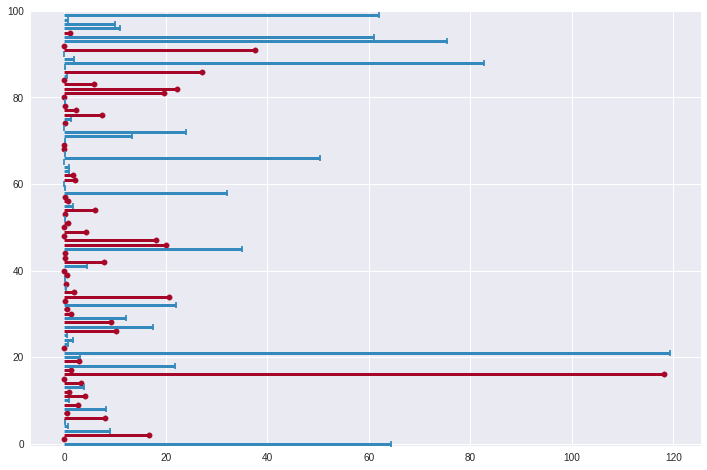

In [27]:
"""
plot_lifetimes takes two arguments:
lifetimes is the duration we observed
event_observed whether the above duration is censored or not
"""

censored_df = censored_df.sample(frac=1)
fig = plt.figure(figsize=(12, 8))
plot_lifetimes(
    lifetimes=censored_df['duration_day'].iloc[:100].values,
    event_observed=1 - censored_df['censored'].iloc[:100].values
);

In [13]:
"""
The above graph can be useful in some circumstances. But it very quickly becomes unreadable
""";

####  --- Theory ---  
We introduced random variable T in the preceding "theory cell". It might be useful to emphasize that for the time being we can understand it as follows:
<b>We presuppose the existence of such variable, what we have to estimate it is data. Each row is one specific realization of it. Sometimes we observe exact quantity of it, for example 1.34 days, sometimes we are given only the information such as "at least 2.23 days". </b>

####  --- Theory ---  
Very often we are interested in survival function S(t). 

There are some classical approaches to estimate it. One of the oldest one is Kaplan-Meier estimator. https://en.wikipedia.org/wiki/Kaplan%E2%80%93Meier_estimator

The process of calculation might not be easy at first. Let's make use of something calles "survival table". We can get it from lifelines package. 

After introducing it, we'll see how the calculations work. 

In [14]:
from lifelines.utils import survival_table_from_events

In [15]:
survival_table = survival_table_from_events(
    death_times=censored_df['duration_day'],
    event_observed=1 - censored_df['censored']
)

In [16]:
survival_table.head()

,removed,observed,censored,entrance,at_risk
event_at,,,,,
0.000000,0,0,0,50000,50000
0.000012,58,24,34,0,50000
0.000023,47,23,24,0,49942
0.000035,41,21,20,0,49895
0.000046,40,19,21,0,49854


#### ---- Theory ---- 
On the wikipedia the estimator of survival function looks ugly. Let's do a couple of iterations and we'll see that 
it is quite simple.

- S(0) = 1 - (number of events at 0) / (number of survivals at 0) = 1 - 0 / 50000 = 1
- S(0.000012) = [1 - (number of events at 0) / (number of survivals at 0)] * S(0) = (1 - 24/50000) = 0.99952 
- S(0.000023) = [1 - (number of events at 0) / (number of survivals at 0)] * S(0.000012) = (1 - 23/49942) * 0.99952 = 0.999059

We won't dwell much on it. Let's use the implementation from lifelines to make our lives easier.

In [20]:
from lifelines import KaplanMeierFitter

In [21]:
kmf = KaplanMeierFitter()
kmf.fit(
    durations=censored_df['duration_day'],
    event_observed=1 - censored_df['censored']
)

<lifelines.KaplanMeierFitter: fitted with 50000 observations, 25134 censored>

In [22]:
# let's look if we have done calculations correctly
kmf.survival_function_.head()

,KM_estimate
timeline,
0.000000,1.000000
0.000012,0.999520
0.000023,0.999060
0.000035,0.998639
0.000046,0.998259


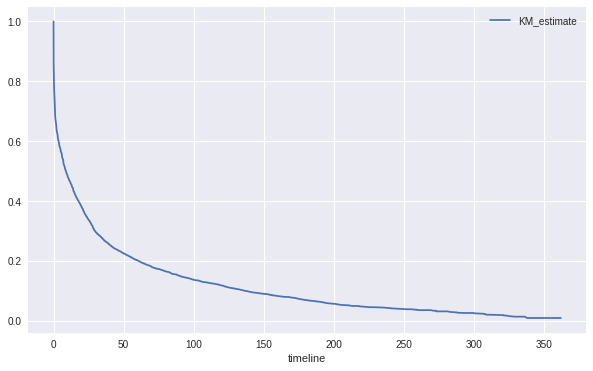

In [28]:
# let's plot it.
# This is our estimatior of survival function of random variable T.
kmf.survival_function_.plot(figsize=(10, 6))

#### ---- Theory ---- 
We can read some information off the above plot. For example, there is a probability of 0.2 that we have to wait for the second visit to happen more than 50 days. 

Important note: <br>
What we have obtained here is the result of our assumptions. One, which is for sure violated, it is the assumption the visits don't differ between each other. Each one is a realization of T (just like tossing a coin). Actually T depends on some factors we haven't taken into account. 

In the next cells we will differentiate visits according to some categorical value. Later, we will model it freely, as freely as regression or classification problem, i.e. T = function($X_{1}$, .., $X_{d}$).

In [31]:
visitors_data = pd.read_csv('data/visitors_data.csv', dtype={'fullVisitorId': str})

In [33]:
visitors_data.head(1)

,fullVisitorId,channelGrouping,visitStartTime,totals_bounces,totals_hits,totals_pageviews,totals_transactionRevenue,device_browser,device_is_mobile,geo_network_city,geo_network_continent,traffic_source,visit_number
0,0000040862739425590,Paid Search,2017-02-11 18:09:31,0.0,2.0,2.0,0.0,Chrome,False,Oakland,Americas,google,1


In [35]:
# we will use channelGrouping as distinctor, because this columns doesn't have so many levels
visitors_data['channelGrouping'].value_counts()

Organic Search    62510
Referral          33634
Direct            29334
Social            12743
Paid Search        7384
Affiliates         3122
Display            2536
(Other)              59
Name: channelGrouping, dtype: int64

In [36]:
censored_df = censored_df.merge(visitors_data[['fullVisitorId', 'channelGrouping']],
                               how='inner', 
                               on='fullVisitorId')

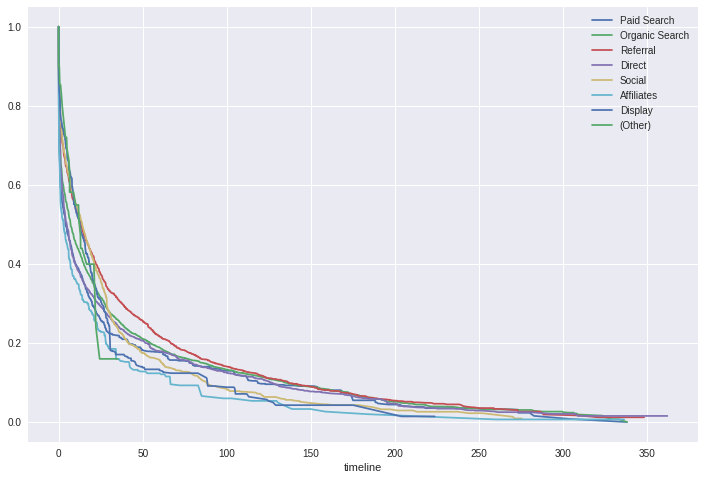

In [39]:
levels = visitors_data['channelGrouping'].unique()
kmf = KaplanMeierFitter()
ax = plt.subplot(111)
for level in levels:
    kmf.fit(
        durations=censored_df.loc[censored_df['channelGrouping'] == level, 'duration_day'].values,
        event_observed=1 - censored_df.loc[censored_df['channelGrouping'] == level, 'censored'].values
    )
    kmf.survival_function_.columns = [level]
    kmf.survival_function_.plot(ax=ax, figsize=(12, 8))

#### ---- Theory ---- 
Now, we can talk about more abstract things that will be useful in our adventure in survival analysis world. We mostly talked about survival function S(t). The another important concept is hazard function, denoted as $\lambda$(t).

It is defined as follows: <br><br>
$\lambda$(t) = $\frac{P(t <= T < t + dt|T >= t)}{dt}$. 

We can imagine that it reflects probability/possibility of the event to happen in the given interval [t, t + dt]. <br><br>
We can rewrite this expression as follows: <br> <br>
$\lambda$(t) = $\frac{P(t <= T < t + dt, T >= t)}{P(T >= t)dt}$ = $\frac{P(t <= T < t + dt)}{P(T >= t)dt}$ = $\frac{f(t)dt}{(1 - F(t))dt}$ = $\frac{f(t)}{S(t)}$

The hazard function $\lambda$(t) is quite important in the survival analysis. So is the cumulative hazard function, but before introducing it, let's more closely explore the relation between survival function S(t) and hazard function $\lambda$(t). 

As (it is basic fact from probability theory, not part of survival analysis): <br><br>
F(t) = $\int_{-\infty}^{t}f(t)dt$, and f(t) = $F^{'}(t)$, and f(t) = -$S^{'}(t)$. We can write: <br><br>
$\lambda$(t) = $\frac{-S^{'}(t)}{S(t)}$, which is the same as:<br><br>
$\lambda$(t) = -$\frac{d}{dt}$log(S(t)), from this we get the useful relation:

log(S(t)) = -$\int_{0}^{t}\lambda(t)$dt, and finally:

S(t) = $e^{-\int_{0}^{t}\lambda(t)dt}$. <br><br>
It turns out that it is useful to define cumulative hazard function: <br>
$\Lambda$(t) = $\int_{0}^{t}\lambda(t)dt$. 


The last quantity has nice interpretation as the sum of risks (hazards) it is experienced as we move along timeline.
This cumulative hazard function should diverge to infinity. 
<br><br>

Finally, we can write:

S(t) = $e^{-\Lambda(t)}$ 

#### ---- Theory ----

As there is a very direct relation between Survival function and Hazard function, we can choose one. 
It turns out that hazard function is easier to work with. 

Let's introduce the Cox model: <br><br>
$\lambda$(t|$X_{i}$) = $\lambda_{0}$(t)$e^{\beta_{1}X_{i1} + .. + \beta_{p}X_{ip}}$

$X_{i}$ is the vector of covariates, for example in the context of e-commerce it could be country, size or the type of the customer.


Basically, we model hazard function as a function of covariates. $\lambda_{0}$(t) is a baseline hazard function, it doesn't depend on covariates. It depends only on duration of observation, t.

Also we can notice that the shape of hazard function is the same as baseline $\lambda_{0}$. We can only move it up and down depending on covariates. 

It is the formulation. Our task is to estimate parameters of the model. As it is often the case in the classic statistics we formulate likelihood function, which then we maximize. The method is very popular and is called maximum likelihood estimation (or MLE for short). We will do so in the next notebook, where we will study modeling phase more carefully. Here, let's use implementation provived by lifelines.

In the next notebook, we will split our data into train/valid sets and assess our results more quantitatively. Here, we want to familiarize ourselves, at least a bit, to the tools provided by the classical theory of survival analysis.

In [40]:
from lifelines import CoxPHFitter

In [41]:
censored_df.head(1)

,fullVisitorId,first_visit,second_visit,duration,duration_day,censored,censored_durations,channelGrouping
0,1150358308665544006,2016-12-04 10:02:54,2017-02-04 11:50:42,5363268.0,62.074861,1,23.775987,Organic Search


In [43]:
# lets add additional feature "was there some transaction".
censored_df = censored_df.merge(
    visitors_data[['fullVisitorId', 'totals_transactionRevenue']], 
    how='inner', 
    on='fullVisitorId'
)
censored_df['totals_transactionRevenue'] = (censored_df['totals_transactionRevenue'] > 0).astype(int)

In [44]:
censored_df.head(1)

,fullVisitorId,first_visit,second_visit,duration,duration_day,censored,censored_durations,channelGrouping,totals_transactionRevenue
0,1150358308665544006,2016-12-04 10:02:54,2017-02-04 11:50:42,5363268.0,62.074861,1,23.775987,Organic Search,0


In [45]:
censored_df['observed'] = 1 - censored_df['censored']

In [46]:
levels = list(censored_df['channelGrouping'].unique())
for level in levels:
    censored_df[level] = (censored_df['channelGrouping'] == level).astype(int)

In [47]:
censored_df.head(1)

,fullVisitorId,first_visit,second_visit,duration,duration_day,censored,censored_durations,channelGrouping,totals_transactionRevenue,observed,Organic Search,Referral,Direct,Paid Search,Social,Display,Affiliates,(Other)
0,1150358308665544006,2016-12-04 10:02:54,2017-02-04 11:50:42,5363268.0,62.074861,1,23.775987,Organic Search,0,0,1,0,0,0,0,0,0,0


In [48]:
cox_model = CoxPHFitter()
cox_model.fit(
    censored_df[['duration_day', 'observed', 'totals_transactionRevenue'] + levels], 
    duration_col='duration_day',
    event_col='observed', 
    show_progress=True
)

Iteration 1: norm_delta = 0.36823, step_size = 0.95000, ll = -6156987.51979, seconds_since_start = 71.6
Iteration 2: norm_delta = 1.89678, step_size = 0.95000, ll = -6137614.83473, seconds_since_start = 142.7
Iteration 3: norm_delta = 0.94001, step_size = 0.95000, ll = -6135643.53584, seconds_since_start = 217.5
Iteration 4: norm_delta = 0.11697, step_size = 0.93100, ll = -6135610.21895, seconds_since_start = 288.5
Iteration 5: norm_delta = 0.37212, step_size = 0.95000, ll = -6135610.08831, seconds_since_start = 362.0
Iteration 6: norm_delta = 0.27658, step_size = 0.93100, ll = -6135610.08767, seconds_since_start = 441.4
Iteration 7: norm_delta = 0.21406, step_size = 0.91238, ll = -6135610.08767, seconds_since_start = 513.5
Convergence completed after 7 iterations.


<lifelines.CoxPHFitter: fitted with 1067378 observations, 584874 censored>

In [49]:
cox_model.print_summary()

n=1067378, number of events=482504

                            coef  exp(coef)  se(coef)      z      p  lower 0.95  upper 0.95     
totals_transactionRevenue 0.0421     1.0430    0.0082 5.1433 0.0000      0.0261      0.0582  ***
Organic Search            4.6237   101.8670       nan    nan    nan         nan         nan     
Referral                  4.3972    81.2205       nan    nan    nan         nan         nan     
Direct                    4.9294   138.2968       nan    nan    nan         nan         nan     
Paid Search               5.4466   231.9782       nan    nan    nan         nan         nan     
Social                    4.4467    85.3424       nan    nan    nan         nan         nan     
Display                   4.4801    88.2418       nan    nan    nan         nan         nan     
Affiliates                4.7390   114.3179       nan    nan    nan         nan         nan     
(Other)                   4.8135   123.1620       nan    nan    nan         nan         nan

In [50]:
"""
To assess goodness of fit we we use concordance-index. Its value lies between 0 and 1.
The biggest, the better.
The citation from https://lifelines.readthedocs.io/en/latest/Survival%20Regression.html#cox-s-proportional-hazard-model
 - 0.5 is the expected result from random predictions
 - 1.0 is perfect concordance and
 - 0.0 is perfect anti-concordance (multiply predictions with -1 to get 1.0)
 
We can under the table 0.578 value for this metric.
We can also get this number directly through object's field:
"""
cox_model.score_

0.57758186525756516

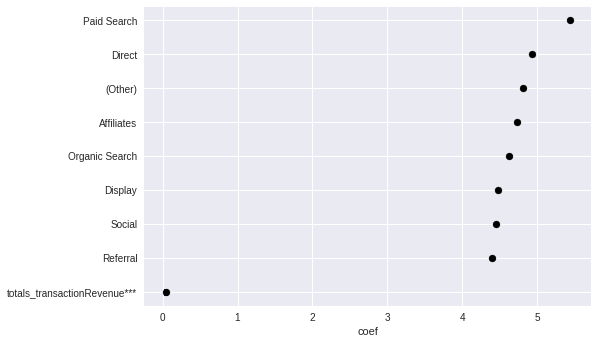

In [51]:
# we can also plot found coefficients
cox_model.plot()

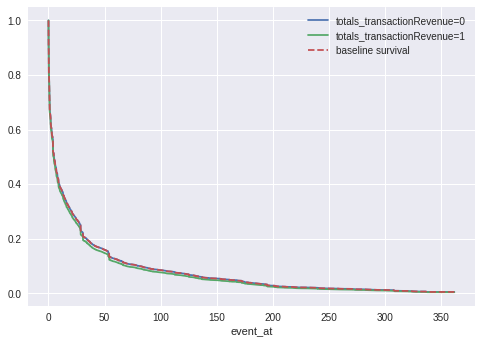

In [53]:
# we can also plot the impact of changing one variable. For more details look at the documentation of lifelines
cox_model.plot_covariate_groups('totals_transactionRevenue', [0, 1]);

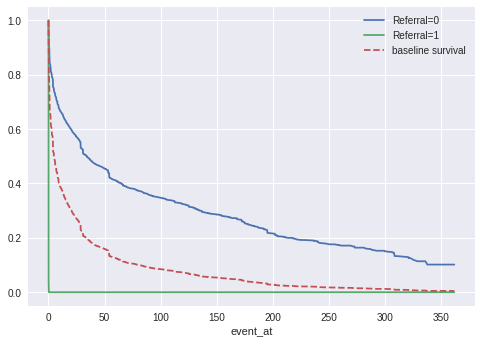

In [59]:
cox_model.plot_covariate_groups('Referral', [0, 1]);

In [62]:
"""
On the above plot we can see strange characteristics.
Fitted survival function is almost vertical, i.e. S(t) = 0, for t > 0.

Found coefficients are large, for example for "Referral" column 4.3972, which after expontiating is equal to 81.2205. 
If you look carefully at relation between Survival function and hazard function, you'll understand why survival function
behaves this way.

Comments:
Fitted model might not be the best, concordance coefficients is not so high
Cox model needs some conditions to be satisfied before applying, we neglected this stage

In general this method might be useful for small datasets, where number of columns is small and well understood. 
We have to understand that one day statisticians use models to understand data better (association, causality), not to
win machine learning competition.
""";